In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular.all import *
from multiprocessing import Pool
from sklearn.model_selection import KFold, GroupKFold
import lightgbm as lgb
from optiver_features import *
import pickle

In [9]:
df = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
time_ids = df.time_id.unique()
np.random.seed(42)
np.random.shuffle(time_ids)

splt = int(len(time_ids)*.7)
train_ids, test_ids = time_ids[:splt], time_ids[splt:]

len(train_ids), len(test_ids)

(2681, 1149)

In [11]:
len(df[df.time_id.isin(train_ids)]) / len(df)

0.6999944047075061

## Generate 5m dataset

In [12]:
book_feature_dict = {
    wap1: [],
    wap2: [],
    log_return1: [np.std],
    log_return2: [np.std],
  
    price_spread:[np.mean],
    total_volume:[np.mean],
}
trade_feature_dict = {
        log_return_price: [np.std],
        'seconds_in_bucket':[np.size],
        'size':[np.sum],
        'order_count':[np.sum],
}
time_id_features=[]
time_id_aggregations = []
stock_id_features = []
stock_id_aggregations = [time_id_aggregations]
time_windows = [(0,300), (0,100), (100,200), (200,300)]

In [15]:
def generate_0_to_5():


    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
    train_df5m = ofg.generate_train_df()
    ofg_targ =OptiverFeatureGenerator({wap1:[], log_return1:[realized_volatility]}, {'seconds_in_bucket':[np.size]}, [(300,600)], [],[],[],[])
    targ_df = ofg_targ.generate_train_df()
    train_df5m.target = targ_df.log_return1_realized_volatility_300_600
    train_df5m.target = train_df5m.target.replace(0, 1e-4)
    return train_df5m
    

In [16]:
%%time
train_df5m = generate_0_to_5()

CPU times: user 2.59 s, sys: 773 ms, total: 3.36 s
Wall time: 4min 41s


In [19]:

train_df5m.to_feather('train_5m.feather')

In [20]:
def rename_col(x):
    return x.replace('300', '600').replace('200', '500').replace('100', '400').replace('_0', '_300')
def rename_col_back(x):
    return x.replace('300', '0').replace('400', '100').replace('500', '200').replace('600', '300')

def generate_5_to_10():
    tw = [(x+300, y+300) for x,y in time_windows]
    time_id_feat = [rename_col(x) for x in time_id_features]
    stock_id_feat = [rename_col(x) for x in stock_id_features]
    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, tw, time_id_feat,time_id_aggregations, stock_id_feat, stock_id_aggregations)

    df = ofg.generate_train_df()
    df.columns = [rename_col_back(x) for x in df.columns]
    return df

In [21]:
train_df5_10m  = generate_5_to_10()

In [22]:
train_df5_10m.to_feather('train_5_10.feather')

## LGBM Baseline

In [23]:
def rmspe_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe_np(y_true, y_pred), False

def train_models(train):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    x = train
    # Split features and target
    for c in ['row_id', 'target', 'time_id']:
        if c in x.columns:
            x = x.drop(c, axis=1)
    
    y = train['target']
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    models =[]
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create a KFold object
    kfold = GroupKFold()
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x, groups = train.time_id)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 3000, 
                          early_stopping_rounds = 25, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        models.append(model)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        #test_predictions += model.predict(x_test) / 10
        
    rmspe_score = rmspe_np(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return models

In [24]:
_=train_models(train_df5m)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000355186	training's RMSPE: 0.24298	valid_1's rmse: 0.000368197	valid_1's RMSPE: 0.252232
[200]	training's rmse: 0.0003469	training's RMSPE: 0.237312	valid_1's rmse: 0.000365066	valid_1's RMSPE: 0.250087
[300]	training's rmse: 0.000342761	training's RMSPE: 0.234481	valid_1's rmse: 0.000363882	valid_1's RMSPE: 0.249276
[400]	training's rmse: 0.00033963	training's RMSPE: 0.232339	valid_1's rmse: 0.000362931	valid_1's RMSPE: 0.248625
Early stopping, best iteration is:
[420]	training's rmse: 0.000339097	training's RMSPE: 0.231974	valid_1's rmse: 0.000362848	valid_1's RMSPE: 0.248568
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000356003	training's RMSPE: 0.243037	valid_1's rmse: 0.000371874	valid_1's RMSPE: 0.256836
[200]	training's rmse: 0.000347838	training's RMSPE: 0.237463	valid_1's rmse: 0.00036887	valid_1's RMSPE: 0.254761
Early stopping, best

## Learning embeddings

In [25]:
cont_nn,cat_nn = cont_cat_split(train_df5m, max_card=9000, dep_var='target')
cat_nn = ['time_id', 'stock_id']


procs_nn = [Categorify, FillMissing,Normalize]

splits = RandomSplitter(valid_pct=0.1,seed=43)(train_df5m)

dls = TabularPandas(train_df5m, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

def rmse(preds, targs):
    x = (targs-preds)
    return (x**2).mean().sqrt()

def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[.5,.2,0], 'embed_p':0.5, }
learn = tabular_learner(dls, y_range=(0,.1), layers=[200,100,40], emb_szs={'stock_id':10, 'time_id':10}, 
                        n_out=1, 
                        loss_func = rmspe, 
                        
                        metrics=AccumMetric(rmspe), config=config)

In [26]:
learn.fit_one_cycle(20, 5e-3)

epoch,train_loss,valid_loss,rmspe,time
0,8.135974,5.782270,5.787799,00:09
1,0.782035,0.369460,0.375036,00:03
2,0.333171,0.281151,0.281615,00:03
3,0.284661,0.262743,0.262974,00:03
4,0.319393,0.269287,0.269765,00:03
5,0.270450,0.253060,0.253552,00:03
6,0.261866,0.234534,0.234932,00:03
7,0.253596,0.233359,0.233680,00:03
8,0.253997,0.232732,0.233226,00:03
9,0.251912,0.228656,0.229007,00:03


In [27]:
categorify = dls.procs[2]
time_embs = learn.model.embeds[0].weight.data.cpu()
stock_embs = learn.model.embeds[1].weight.data.cpu()

In [28]:
def append_embs(data_df, categorify, time_embs, stock_embs):
    time_id_embs = dict()
    for idx, time_id in enumerate(categorify.classes['time_id']):
        time_id_embs[time_id] = time_embs[idx].tolist()

    stock_id_embs = dict()
    for idx, stock_id in enumerate(categorify.classes['stock_id']):
        stock_id_embs[stock_id] = stock_embs[idx].tolist()

    all_embs = []
    for _, row in (data_df[['stock_id', 'time_id']].iterrows()):
        emb1 = stock_id_embs[row.stock_id]
        emb2 = time_id_embs[row.time_id]
        all_embs.append(emb1+emb2)
    columns = [f'stock_emb{i}' for i in range(stock_embs.shape[1])] +[f'time_emb{i}' for i in range(time_embs.shape[1])]
    embs_df = pd.DataFrame(all_embs, columns=columns)

    return pd.concat([data_df, embs_df], axis=1)

In [29]:
test_df = train_df5_10m
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)
preds5_10 = preds.view(-1).numpy()

## Train 5m LGBM with embeddings


In [30]:
train_5_with_embs = append_embs(train_df5m, categorify, time_embs, stock_embs)



In [31]:
_=train_models(train_5_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.00032345	training's RMSPE: 0.22127	valid_1's rmse: 0.00033428	valid_1's RMSPE: 0.228998
[200]	training's rmse: 0.000315039	training's RMSPE: 0.215516	valid_1's rmse: 0.000330529	valid_1's RMSPE: 0.226428
[300]	training's rmse: 0.000310974	training's RMSPE: 0.212735	valid_1's rmse: 0.000329051	valid_1's RMSPE: 0.225416
[400]	training's rmse: 0.000307741	training's RMSPE: 0.210524	valid_1's rmse: 0.000328142	valid_1's RMSPE: 0.224793
[500]	training's rmse: 0.000305581	training's RMSPE: 0.209046	valid_1's rmse: 0.00032755	valid_1's RMSPE: 0.224387
Early stopping, best iteration is:
[504]	training's rmse: 0.000305463	training's RMSPE: 0.208965	valid_1's rmse: 0.000327545	valid_1's RMSPE: 0.224384
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000323976	training's RMSPE: 0.221173	valid_1's rmse: 0.000339944	valid_1's RMSPE: 0.234783
[200]	training's rm

## Baseline LGBM 10m

In [191]:
# time_windows = [(0,600), (200, 600), (400,600)]

# agg_cols = ['log_return_price_std', 'log_return1_std', 'log_return2_std']

# time_id_features = [f'{col}_{x}_{y}' for x,y in time_windows for col in agg_cols] 
# time_id_aggregations = ['mean', 'std', 'min' ]
# stock_id_features = time_id_features
# stock_id_aggregations = time_id_aggregations

# ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
# df = ofg.generate_train_df()



In [192]:
# cols_to_keep = ['log_return2_std_0_600',
 
#  'stock_id','row_id', 'time_id', 'target',
#  'log_return_price_std_0_600',
#   'order_count_sum_0_600',
#  'seconds_in_bucket_size_0_600',
#  'size_sum_0_600',
#  'log_return1_std_0_600_min_time',
#  'log_return1_std_0_600_mean_time',
#  'log_return1_std_0_600_min_stock',
#  'log_return1_std_0_600_mean_stock',
#  'log_return1_std_0_600',
#  'log_return1_std_200_600',
#  'log_return1_std_400_600',
#  'price_spread_mean_0_600',
#  'log_return_price_std_0_600_mean_time',
#  'log_return_price_std_200_600_mean_time',
#  'log_return_price_std_400_600_mean_time',
#  'log_return_price_std_0_600_min_time',
#  'log_return_price_std_200_600_min_time',
#  'log_return_price_std_400_600_min_time',
#  'total_volume_mean_0_600']

# df = df[cols_to_keep]

# df.to_feather('train_24cols.feather')

In [32]:
df = pd.read_feather('train_24cols.feather')

In [33]:
train_df10m = df[df.time_id.isin(train_ids)].reset_index()
test_df10m = df[df.time_id.isin(test_ids)].reset_index()
len(train_df10m), len(test_df10m)

(300250, 128682)

In [34]:
models=train_models(train_df10m)

Training fold 1
Training until validation scores don't improve for 25 rounds


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's rmse: 0.000467282	training's RMSPE: 0.218349	valid_1's rmse: 0.00048106	valid_1's RMSPE: 0.220792
[200]	training's rmse: 0.000449861	training's RMSPE: 0.210209	valid_1's rmse: 0.000475599	valid_1's RMSPE: 0.218285
[300]	training's rmse: 0.000441072	training's RMSPE: 0.206102	valid_1's rmse: 0.000473911	valid_1's RMSPE: 0.21751
Early stopping, best iteration is:
[363]	training's rmse: 0.00043607	training's RMSPE: 0.203765	valid_1's rmse: 0.000473137	valid_1's RMSPE: 0.217155
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000468436	training's RMSPE: 0.217662	valid_1's rmse: 0.000477137	valid_1's RMSPE: 0.224011
[200]	training's rmse: 0.000451397	training's RMSPE: 0.209744	valid_1's rmse: 0.000474375	valid_1's RMSPE: 0.222714
Early stopping, best iteration is:
[235]	training's rmse: 0.000447641	training's RMSPE: 0.207999	valid_1's rmse: 0.000473793	valid_1's RMSPE: 0.222441
Training fold 3
Training until validation sc

In [35]:
test_pred = np.zeros(len(test_df10m))
for model in models:
    pred = model.predict(test_df10m.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

baseline_score = rmspe_np(test_df10m.target, test_pred)
baseline_score

0.22725182948338465

## LGBM 10m with trained embeddings

In [36]:
df_with_embs = append_embs(df, categorify, time_embs, stock_embs)

In [37]:
df_with_embs['5m_pred']= preds5_10

In [52]:
train_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(train_ids)].reset_index().drop('index',axis=1)
test_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(test_ids)].reset_index().drop('index',axis=1)

In [53]:
train_10m_with_embs.columns

Index(['log_return2_std_0_600', 'stock_id', 'row_id', 'time_id', 'target',
       'log_return_price_std_0_600', 'order_count_sum_0_600',
       'seconds_in_bucket_size_0_600', 'size_sum_0_600',
       'log_return1_std_0_600_min_time', 'log_return1_std_0_600_mean_time',
       'log_return1_std_0_600_min_stock', 'log_return1_std_0_600_mean_stock',
       'log_return1_std_0_600', 'log_return1_std_200_600',
       'log_return1_std_400_600', 'price_spread_mean_0_600',
       'log_return_price_std_0_600_mean_time',
       'log_return_price_std_200_600_mean_time',
       'log_return_price_std_400_600_mean_time',
       'log_return_price_std_0_600_min_time',
       'log_return_price_std_200_600_min_time',
       'log_return_price_std_400_600_min_time', 'total_volume_mean_0_600',
       'stock_emb0', 'stock_emb1', 'stock_emb2', 'stock_emb3', 'stock_emb4',
       'stock_emb5', 'stock_emb6', 'stock_emb7', 'stock_emb8', 'stock_emb9',
       'time_emb0', 'time_emb1', 'time_emb2', 'time_emb3', 'time

In [54]:
models=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000457185	training's RMSPE: 0.213631	valid_1's rmse: 0.000477803	valid_1's RMSPE: 0.219297
[200]	training's rmse: 0.000439114	training's RMSPE: 0.205187	valid_1's rmse: 0.00047547	valid_1's RMSPE: 0.218226
Early stopping, best iteration is:
[185]	training's rmse: 0.000441406	training's RMSPE: 0.206258	valid_1's rmse: 0.000475241	valid_1's RMSPE: 0.218121
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000459879	training's RMSPE: 0.213686	valid_1's rmse: 0.000474259	valid_1's RMSPE: 0.22266
[200]	training's rmse: 0.000441425	training's RMSPE: 0.205111	valid_1's rmse: 0.000472391	valid_1's RMSPE: 0.221783
Early stopping, best iteration is:
[179]	training's rmse: 0.000444418	training's RMSPE: 0.206501	valid_1's rmse: 0.000471807	valid_1's RMSPE: 0.221509
Training fold 3
Training until validation scores don't improve for 25 rounds
[100]	training's rmse

In [55]:
test_pred = np.zeros(len(test_10m_with_embs))
for model in models:
    pred = model.predict(test_10m_with_embs.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

embeds5mpred_score = rmspe_np(test_10m_with_embs.target, test_pred)
embeds5mpred_score

0.22192612134715417

In [56]:
(baseline_score-embeds5mpred_score)/ baseline_score

0.023435270678953405

In [ ]:
# for m in models[:2]:
#     lgb.plot_importance(m, max_num_features=20)

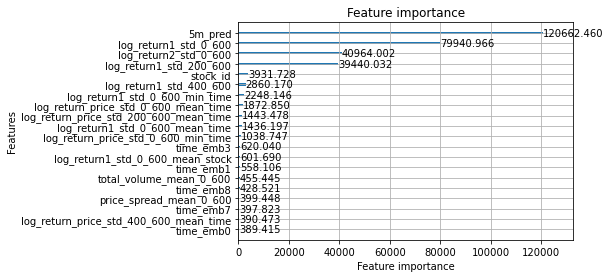

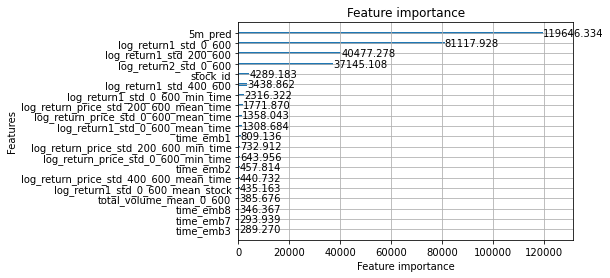

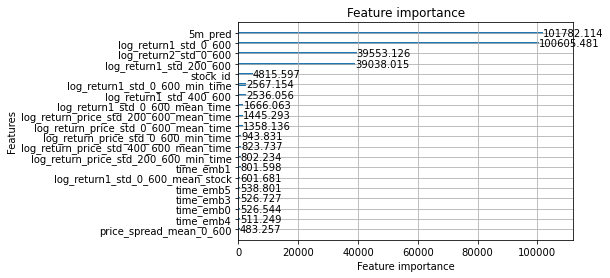

In [57]:
for m in models[:3]:
    lgb.plot_importance(m, max_num_features=20, importance_type='gain')

## Train NN

In [58]:
splits = first(GroupKFold().split(train_10m_with_embs, groups = train_10m_with_embs.time_id))
splits = (list(splits[0]), list(splits[1]))

In [59]:
cont_nn,cat_nn = cont_cat_split(train_10m_with_embs, max_card=9000, dep_var='target')
cat_nn = []


procs_nn = [Categorify, FillMissing,Normalize]

#splits = RandomSplitter(valid_pct=0.2,seed=43)(train_10m_with_embs)

dls = TabularPandas(train_10m_with_embs, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

def rmse(preds, targs):
    x = (targs-preds)
    return (x**2).mean().sqrt()

def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[0.5,0,0], }
learn = tabular_learner(dls, y_range=(0,.1), layers=[200,100,10], 
                        n_out=1, 
                        loss_func = rmspe, 
                        
                        metrics=AccumMetric(rmspe), config=config)

In [61]:
learn.fit_one_cycle(40, 5e-3, wd=.1)

epoch,train_loss,valid_loss,rmspe,time
0,11.606947,10.577265,10.592472,00:01
1,6.987443,5.093297,5.148812,00:01
2,2.415123,1.422998,1.462633,00:01
3,0.987373,0.546916,0.599882,00:01
4,0.582206,0.304575,0.360454,00:01
5,0.372477,0.256552,0.267001,00:01
6,0.312593,0.243407,0.245972,00:01
7,0.268088,0.227544,0.229842,00:01
8,0.533095,0.609217,0.708675,00:01
9,0.273078,0.240214,0.241697,00:01


In [63]:

test_dl = dls.test_dl(test_10m_with_embs)
preds, _ = learn.get_preds(dl=test_dl)

In [65]:
score =rmspe_np(test_10m_with_embs.target, preds.view(-1).numpy())
score

0.21936485990884572

In [66]:
(baseline_score-score)/ baseline_score

0.034705857341032265